In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,  precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import time
torch.manual_seed(42)
np.random.seed(42)

# First Feature Map

In [2]:

# Configuration
n_qubits = 2
input_dim = 2
res = 30  # resolution of x1, x2 grid
X_vals = np.linspace(0, 2 * np.pi, res)
X1, X2 = np.meshgrid(X_vals, X_vals)
inputs = np.stack([X1.ravel(), X2.ravel()], axis=1)


In [3]:

# Encoding
def encoding_layer(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RY(x[0]*x[1], wires=0)
    qml.RY(x[1]*x[0], wires=1)
    
# Variational block
def variational_block(weights):
    for i in range(n_qubits):
        qml.RZ(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RZ(weights[i, 2], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])

# Create circuit
def create_qnode(depth, weights, dev,num_reupload):
    @qml.qnode(dev)
    def circuit(x):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(x)
                count += 1
            variational_block(weights[d])
        return qml.expval(qml.PauliZ(0))
    return circuit


In [4]:

# Label from circuit
def generate_labels(circuit, X):
    return np.array([1 if circuit(x) > 0 else 0 for x in X])


In [5]:

# Quantum classifier as TorchLayer
def get_torch_model(depth, dev,num_reupload):
    weight_shapes = {"weights": (depth, n_qubits, 3)}

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        count = 0
        for d in range(depth):
            if count < num_reupload:
                encoding_layer(inputs)
                count += 1
            for i in range(n_qubits):
                qml.RZ(weights[d, i, 0], wires=i)
                qml.RY(weights[d, i, 1], wires=i)
                qml.RZ(weights[d, i, 2], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])
        return qml.expval(qml.PauliZ(0))

    return qml.qnn.TorchLayer(circuit, weight_shapes)


In [6]:
def train_model(model, X_train, y_train, epochs=100, lr=0.1, lambda_l1=0.0, lambda_l2=0.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for _ in range(epochs):
        opt.zero_grad()
        outputs = torch.stack([model(x) for x in X_train])
        loss = loss_fn(outputs, y_train.squeeze())

        # Add L1 and L2 regularization terms
        l1_reg = torch.tensor(0.0, requires_grad=True)
        l2_reg = torch.tensor(0.0, requires_grad=True)
        for param in model.parameters():
            l1_reg = l1_reg + torch.sum(torch.abs(param))
            l2_reg = l2_reg + torch.sum(param ** 2)

        loss = loss + lambda_l1 * l1_reg + lambda_l2 * l2_reg
        loss.backward()
        opt.step()

    return model


In [7]:
def plot_generator_A(generator_labels, title, X=None, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = generator_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, cmap='RdBu', alpha=0.4)
    plt.contour(X1, X2, Z, levels=2, colors='black', linewidths=0.5)

    # Optional: overlay generated class markers on the full grid
    X_flat = X1.ravel(), X2.ravel()
    labels_flat = generator_labels.ravel()
    for cls, marker in zip([0, 1], ['o', 's']):
        idx = labels_flat == cls
        plt.scatter(X_flat[0][idx], X_flat[1][idx], marker=marker, color='black', s=5, alpha=0.3, label=f'Class {cls}')

    # Optional: training points overlay
    if X is not None and train_idx is not None:
        X_train = X[train_idx]
        y_train = generator_labels[train_idx]
        for i, pt in enumerate(X_train):
            marker = 'o' if y_train[i] == 0 else 's'
            plt.scatter(pt[0], pt[1], marker=marker, color='yellow', edgecolor='black', s=40, label="Train point" if i == 0 else None)

    plt.title(title)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:

# Plot contours
def plot_results(generator_labels, predicted_labels, title, X, train_idx=None):
    plt.figure(figsize=(6, 5))
    Z = predicted_labels.reshape(res, res)
    plt.contourf(X1, X2, Z, levels=2, alpha=0.3, cmap='RdBu')
    plt.contour(X1, X2, generator_labels.reshape(res, res), levels=2, colors='black', linewidths=0.5)

    # Plot training points
    if train_idx is not None:
        X_train_pts = X[train_idx]
        y_true = generator_labels[train_idx]
        y_pred = predicted_labels[train_idx]

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)
    if train_idx is None:
        X_train_pts = X
        y_true = generator_labels
        y_pred = predicted_labels

        for i, pt in enumerate(X_train_pts):
            marker = 'o' if y_true[i] == 0 else 's'
            color = 'green' if y_pred[i] == y_true[i] else 'red'
            label = None

            # Add legend once
            if i == 0 and y_true[i] == 0:
                label = 'Class 0 (circle)'
            elif i == 0 and y_true[i] == 1:
                label = 'Class 1 (square)'

            plt.scatter(pt[0], pt[1], color=color, marker=marker, s=40, edgecolor='black', label=label)

        # Ensure both classes appear in legend even if only one example is shown
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 (circle)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Class 1 (square)', markerfacecolor='gray', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Correct (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Wrong (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements)

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    plt.show()



In [9]:

# Main experiment
depths = [1, 2, 3, 4] # depths of reupload
train_idx = np.random.choice(len(inputs), size=300, replace=False)
X_train = torch.tensor(inputs[train_idx], dtype=torch.float32)
test_idx = np.setdiff1d(np.arange(len(inputs)), train_idx)
X_test = torch.tensor(inputs[test_idx], dtype=torch.float32)
reg_configs = [
    {"label": "No Reg", "lambda_l1": 0.0, "lambda_l2": 0.0},
    {"label": "L1",     "lambda_l1": 0.01, "lambda_l2": 0.0},
    {"label": "L2",     "lambda_l1": 0.0, "lambda_l2": 0.01},
    {"label": "L1+L2",  "lambda_l1": 0.01, "lambda_l2": 0.01},
]

results = []


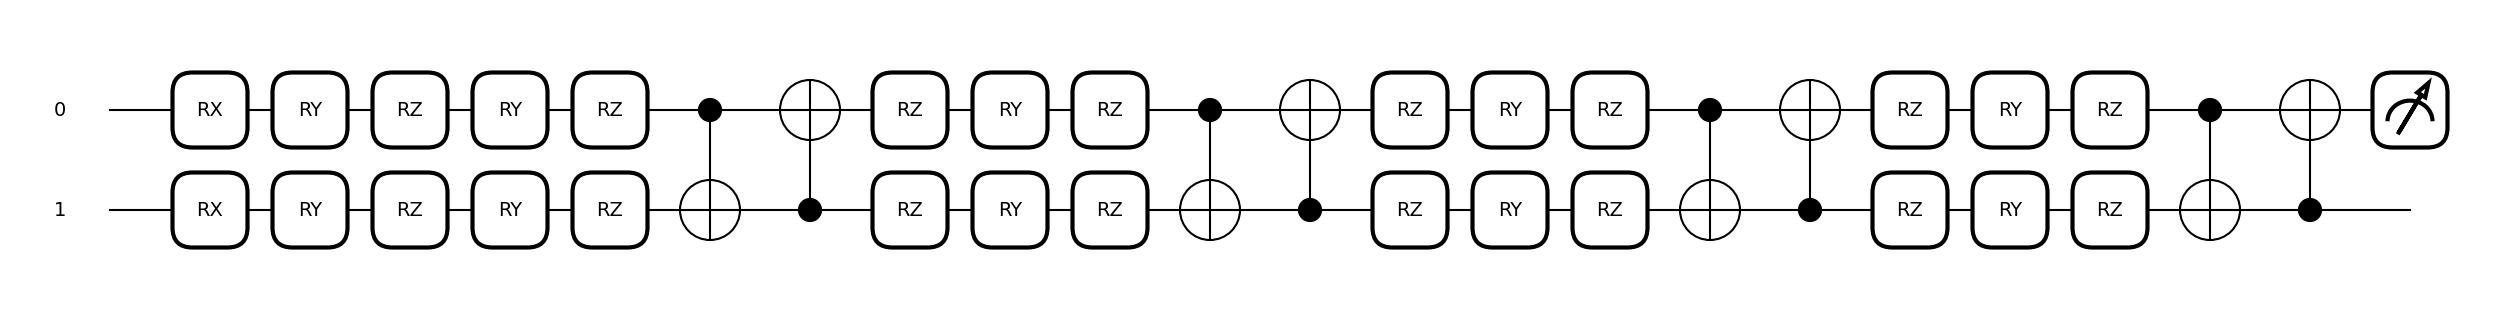

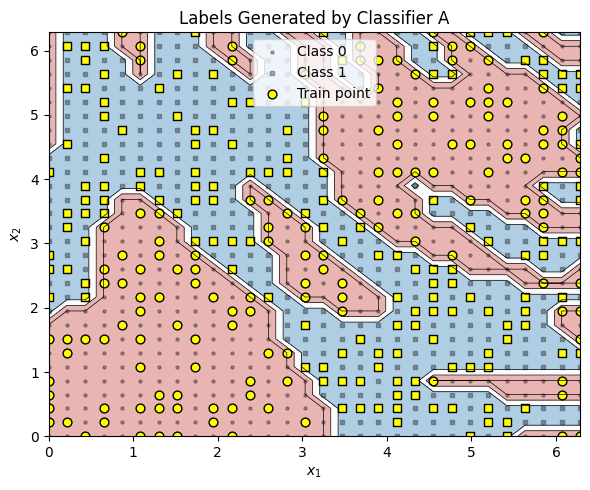

  0%|          | 0/4 [00:00<?, ?it/s]

Training B(regularization=No Reg) on data from A
Total Accuracy: 0.9133333333333333
Train Accuracy: 0.92
Test Accuracy: 0.91
Test Precision: 0.9081632653061225
Test Recall: 0.9081632653061225
Test F1: 0.9081632653061225
Time taken: 233.00631165504456


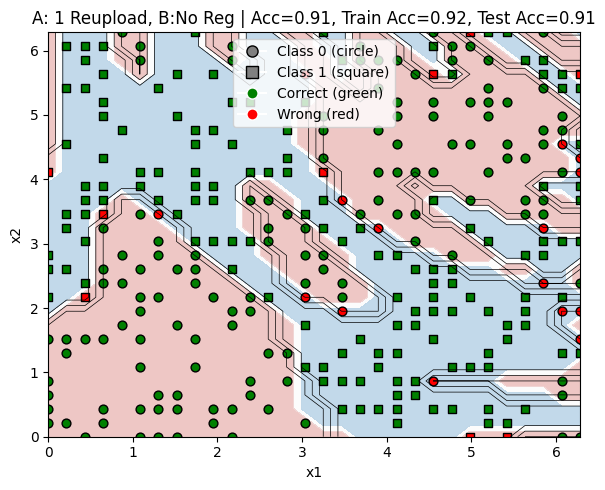

 25%|██▌       | 1/4 [03:53<11:40, 233.67s/it]

Training B(regularization=L1) on data from A
Total Accuracy: 0.9033333333333333
Train Accuracy: 0.93
Test Accuracy: 0.89
Test Precision: 0.8986013986013986
Test Recall: 0.8741496598639455
Test F1: 0.8862068965517242
Time taken: 266.46689677238464


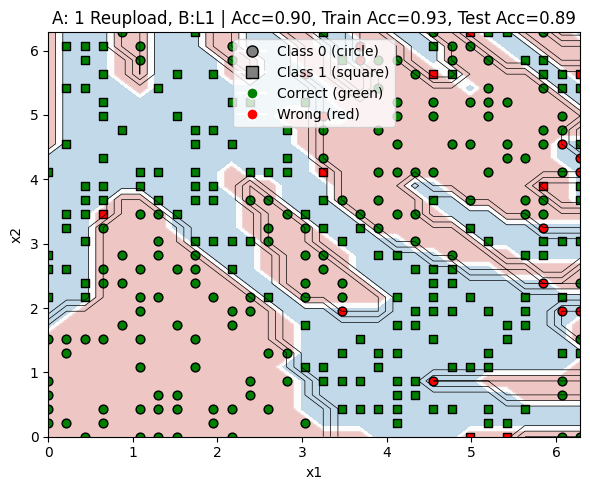

 50%|█████     | 2/4 [08:21<08:27, 253.80s/it]

Training B(regularization=L2) on data from A
Total Accuracy: 0.8866666666666667
Train Accuracy: 0.9
Test Accuracy: 0.88
Test Precision: 0.8908450704225352
Test Recall: 0.8605442176870748
Test F1: 0.8754325259515571
Time taken: 534.0534932613373


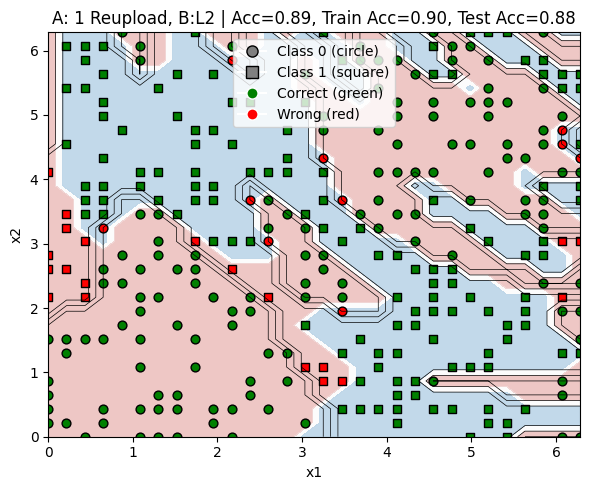

 75%|███████▌  | 3/4 [17:17<06:22, 382.41s/it]

Training B(regularization=L1+L2) on data from A
Total Accuracy: 0.85
Train Accuracy: 0.8666666666666667
Test Accuracy: 0.8416666666666667
Test Precision: 0.8372881355932204
Test Recall: 0.8401360544217688
Test F1: 0.8387096774193549
Time taken: 533.8444108963013


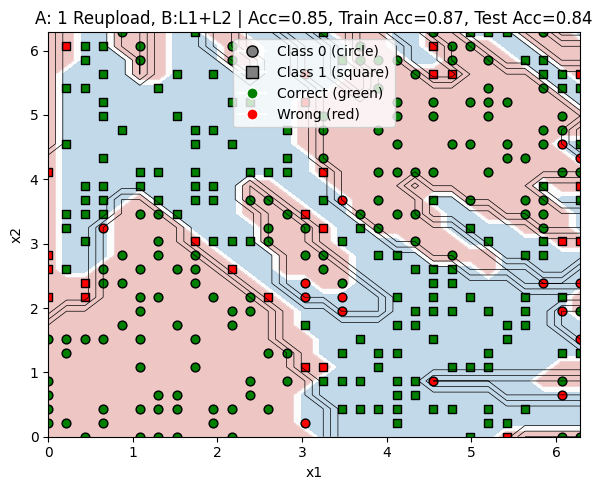

100%|██████████| 4/4 [26:12<00:00, 393.07s/it]


In [10]:


# Generate labels using fixed A
devA = qml.device("default.qubit", wires=n_qubits)
weights_A = np.random.uniform(0, 2*np.pi, size=(4, n_qubits, 3))
circuit_A = create_qnode(4, weights_A, devA, 1)
labels_A = generate_labels(circuit_A, inputs)
y_train = torch.tensor(labels_A[train_idx], dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(labels_A[test_idx], dtype=torch.float32).unsqueeze(1)
qml.drawer.draw_mpl(circuit_A)([0, 1]);

plot_generator_A(labels_A, "Labels Generated by Classifier A", X=inputs, train_idx=train_idx)
for config in tqdm(reg_configs):
    print(f"Training B(regularization={config['label']}) on data from A")
    devB = qml.device("default.qubit", wires=n_qubits)
    model_B = get_torch_model(4, devB, num_reupload=1)
    start_time = time.time()
    trained_model = train_model(model_B, X_train, y_train, 100,0.1,config["lambda_l1"], config["lambda_l2"])

    # Evaluate model
    with torch.no_grad():
        preds = torch.stack([trained_model(x) for x in torch.tensor(inputs, dtype=torch.float32)]).numpy().flatten()
        pred_labels = (preds > 0).astype(int)
        
    train_preds = pred_labels[train_idx]
    test_preds = pred_labels[test_idx]

    acc = accuracy_score(labels_A, pred_labels)
    
    train_acc = accuracy_score(labels_A[train_idx], train_preds)
    test_acc = accuracy_score(labels_A[test_idx], test_preds)
    precision = precision_score(labels_A[test_idx], test_preds)
    recall = recall_score(labels_A[test_idx], test_preds)
    f1 = f1_score(labels_A[test_idx], test_preds)
    # Plot
    title = f"A: 1 Reupload, B:{config['label']} | Acc={acc:.2f}, Train Acc={train_acc:.2f}, Test Acc={test_acc:.2f}"
    print("Total Accuracy:", acc)
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print("Test Precision:", precision)
    print("Test Recall:", recall)
    print("Test F1:", f1)
    print("Time taken:", time.time() - start_time)
    plot_results(labels_A, pred_labels, title, inputs, train_idx)
    
    results.append((1, config["label"], acc, train_acc, test_acc))




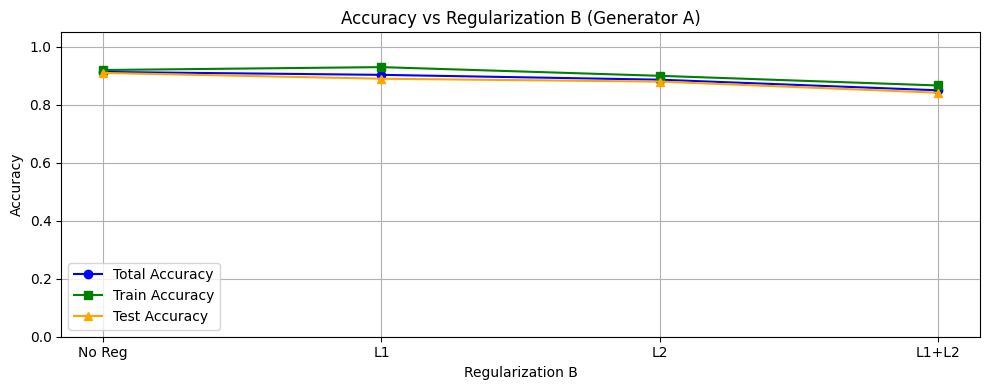

In [11]:

# Updated DataFrame with new columns
df_results = pd.DataFrame(results, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Regularization B (Generator A)")
    plt.xlabel("Regularization B")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
print("done")

done


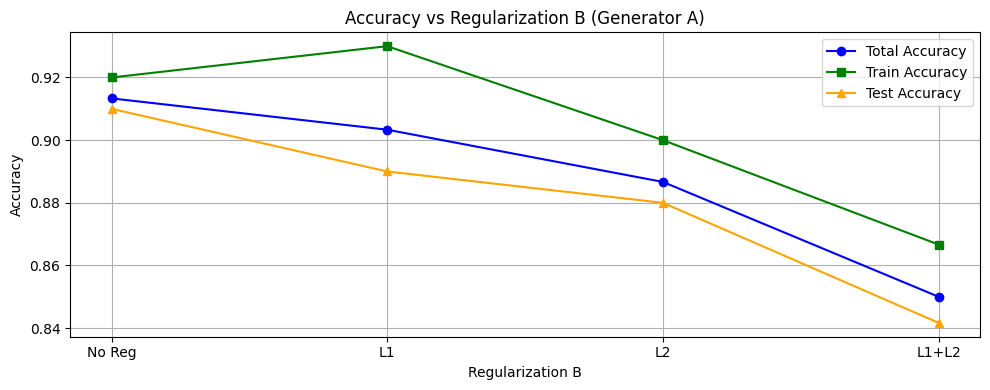

In [13]:

# Updated DataFrame with new columns
df_results = pd.DataFrame(results, columns=["depth_A", "depth_B", "total_acc", "train_acc", "test_acc"])

# Plot for each depth_A
for depth_A in df_results["depth_A"].unique():
    subset = df_results[df_results["depth_A"] == depth_A]

    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.plot(subset["depth_B"], subset["total_acc"], marker='o', label="Total Accuracy", color='blue')
    plt.plot(subset["depth_B"], subset["train_acc"], marker='s', label="Train Accuracy", color='green')
    plt.plot(subset["depth_B"], subset["test_acc"], marker='^', label="Test Accuracy", color='orange')

    plt.title(f"Accuracy vs Regularization B (Generator A)")
    plt.xlabel("Regularization B")
    plt.ylabel("Accuracy")
    # plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
